In [1]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq langchain-groq==0.1.9 --progress-bar off
!pip install -qqq langgraph==0.2.4 --progress-bar off

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-text-splitters 0.3.8 requires langchain-core<1.0.0,>=0.3.51, but you have langchain-core 0.2.43 which is incompatible.
langchain 0.3.25 requires langchain-core<1.0.0,>=0.3.58, but you have langchain-core 0.2.43 which is incompatible.


In [23]:

import os
import sqlite3
from dataclasses import dataclass
from datetime import date
from enum import Enum, auto
from typing import Annotated, List, Literal, Optional, Set, TypedDict

from google.colab import userdata
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

MODEL = "llama3-8b-8192"

llm = ChatGroq(temperature=0, model_name=MODEL, api_key=userdata.get("lama3"))

In [4]:
DB_NAME = "habit_tracker.db"


class DayOfWeek(Enum):
    MONDAY = auto()
    TUESDAY = auto()
    WEDNESDAY = auto()
    THURSDAY = auto()
    FRIDAY = auto()
    SATURDAY = auto()
    SUNDAY = auto()


@dataclass
class Habit:
    id: int
    name: str
    repeat_frequency: Set[DayOfWeek]
    tags: List[str]


@dataclass
class DailyHabitEntry:
    id: int
    name: str
    tags: List[str]
    is_completed: bool


def get_connection():
    return sqlite3.connect(DB_NAME)


def create_tables():
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            CREATE TABLE IF NOT EXISTS habits (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT NOT NULL,
                repeat_frequency TEXT NOT NULL,
                tags TEXT NOT NULL
            )
        """
        )
        cursor.execute(
            """
            CREATE TABLE IF NOT EXISTS completions (
                habit_id INTEGER,
                completion_date TEXT,
                PRIMARY KEY (habit_id, completion_date),
                FOREIGN KEY (habit_id) REFERENCES habits (id)
            )
        """
        )
        conn.commit()


def list_habits() -> List[Habit]:
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM habits")
        return [
            Habit(
                id,
                name,
                {DayOfWeek[day] for day in freq.split(",")},
                tags.split(","),
            )
            for id, name, freq, tags in cursor.fetchall()
        ]


def habits_for_date(date: date) -> List[DailyHabitEntry]:
    weekday = DayOfWeek(date.weekday() + 1).name
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            SELECT h.id, h.name, h.tags, c.completion_date IS NOT NULL as completed
            FROM habits h
            LEFT JOIN completions c ON h.id = c.habit_id AND c.completion_date = ?
            WHERE instr(h.repeat_frequency, ?) > 0
        """,
            (date.isoformat(), weekday),
        )
        return [
            DailyHabitEntry(id, name, tags.split(","), bool(completed))
            for id, name, tags, completed in cursor.fetchall()
        ]


def complete_habit(habit_id: int, completion_date: date):
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            INSERT OR REPLACE INTO completions (habit_id, completion_date)
            VALUES (?, ?)
        """,
            (habit_id, completion_date.isoformat()),
        )
        conn.commit()


def add_habit(name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = []) -> int:
    with get_connection() as conn:
        cursor = conn.cursor()
        cursor.execute(
            """
            INSERT INTO habits (name, repeat_frequency, tags)
            VALUES (?, ?, ?)
        """,
            (name, ",".join(day.name for day in repeat_frequency), ",".join(tags)),
        )
        conn.commit()
        return cursor.lastrowid


def show_habits_for_date(date: date):
    print(f"Habits for {date}:")
    for entry in habits_for_date(date):
        status = "Completed" if entry.is_completed else "Not completed"
        print(f"- {entry.name} (ID: {entry.id}): {status}")
        print(f"  Tags: {', '.join(entry.tags)}")


create_tables()

In [5]:
add_habit("Feed the llamas", {DayOfWeek.SATURDAY, DayOfWeek.SUNDAY}, ["diet"])
add_habit(
    "Hit the gym",
    {DayOfWeek.MONDAY, DayOfWeek.WEDNESDAY, DayOfWeek.FRIDAY},
    ["exercise", "fitness"],
)

2

In [6]:
list_habits()

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness'])]

In [7]:

add_habit("Feed the llamas", {DayOfWeek.SATURDAY, DayOfWeek.SUNDAY}, ["diet"])
add_habit(
    "Hit the gym",
    {DayOfWeek.MONDAY, DayOfWeek.WEDNESDAY, DayOfWeek.FRIDAY},
    ["exercise", "fitness"],
)

4

In [8]:
list_habits()

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']),
 Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness'])]

In [9]:
class CompleteHabitParams(BaseModel):
    habit_id: int = Field(description="Id (number) of the habit e.g. 2")
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to complete the habit e.g. 2024")


@tool(args_schema=CompleteHabitParams)
def complete_habit_tool(habit_id: int, day: int, month: int, year: int):
    """Completes a habit for a specific date"""
    completion_date = date(year, month, day)
    complete_habit(habit_id, completion_date)


class HabitsForDateParams(BaseModel):
    day: int = Field(description="Day of the month (1-31) e.g. 18")
    month: int = Field(description="Month of the year (1-12) e.g. 3")
    year: int = Field(description="Year for which to complete the habit e.g. 2024")


@tool(args_schema=HabitsForDateParams)
def habits_for_date_tool(day: int, month: int, year: int):
    """Returns a list of habits for a given date"""
    return habits_for_date(date(year, month, day))


class AddHabitParams(BaseModel):
    name: str = Field(description="Name of the habit")
    repeat_frequency: Set[DayOfWeek] = Field(
        description="Which days of the week the habit should repeat"
    )
    tags: Optional[List[str]] = Field(
        description="Optional list of tags for this habit"
    )


@tool(args_schema=AddHabitParams)
def add_habit_tool(
    name: str, repeat_frequency: Set[DayOfWeek], tags: List[str] = []
) -> int:
    """Adds a new habit with specific repeat frequency. Returns the ID of the habit."""
    return add_habit(name, repeat_frequency, tags)

In [24]:
tools = [complete_habit_tool, habits_for_date_tool, add_habit_tool]
llm = llm.bind_tools(tools)

In [11]:
class AppState(TypedDict):
    messages: Annotated[list, add_messages]
    habits: List[Habit]

In [12]:

SYSTEM_TEMPLATE = PromptTemplate.from_template(
    """Current habits
{habits}
"""
)


def update_habits(state: AppState):
    return {"habits": list_habits()}


def call_model(state: AppState):
    messages = state["messages"]
    first_message = messages[0]
    system_message = SystemMessage(SYSTEM_TEMPLATE.format(habits=state["habits"]))
    if first_message.type == "system":
        messages[0] = system_message
    else:
        messages.insert(0, system_message)
    response = llm.invoke(messages)
    return {"messages": [response]}


tool_node = ToolNode(tools)

In [13]:
def should_continue(state: AppState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [14]:

graph = StateGraph(AppState)

# nodes of the graph
graph.add_node("update_habits", update_habits)
graph.add_node("agent", call_model)
graph.add_node("tools", tool_node)

# edges between nodes
graph.add_edge("update_habits", "agent")
graph.add_conditional_edges("agent", should_continue)
graph.add_edge("tools", "update_habits")

# start node of the graph
graph.set_entry_point("update_habits")

In [15]:

graph.nodes

{'update_habits': StateNodeSpec(runnable=update_habits(recurse=True), metadata=None, input=<class '__main__.AppState'>, retry_policy=None),
 'agent': StateNodeSpec(runnable=agent(recurse=True), metadata=None, input=<class '__main__.AppState'>, retry_policy=None),
 'tools': StateNodeSpec(runnable=tools(recurse=True, tools_by_name={'complete_habit_tool': StructuredTool(name='complete_habit_tool', description='Completes a habit for a specific date', args_schema=<class '__main__.CompleteHabitParams'>, func=<function complete_habit_tool at 0x799a83decea0>), 'habits_for_date_tool': StructuredTool(name='habits_for_date_tool', description='Returns a list of habits for a given date', args_schema=<class '__main__.HabitsForDateParams'>, func=<function habits_for_date_tool at 0x799a8342a520>), 'add_habit_tool': StructuredTool(name='add_habit_tool', description='Adds a new habit with specific repeat frequency. Returns the ID of the habit.', args_schema=<class '__main__.AddHabitParams'>, func=<funct

In [16]:

graph.edges

{('__start__', 'update_habits'),
 ('tools', 'update_habits'),
 ('update_habits', 'agent')}

In [17]:
graph.channels

{'messages': <langgraph.channels.binop.BinaryOperatorAggregate at 0x799a833ee1d0>,
 'habits': <langgraph.channels.last_value.LastValue at 0x799a98e0da90>}

In [18]:
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

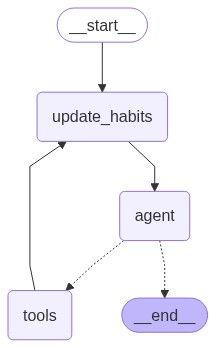

In [19]:
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
config = {"configurable": {"thread_id": 42}}

state = app.invoke(
    {"messages": [HumanMessage(content="Complete the workout for August 14th 2024")]},
    config=config,
)

In [27]:
state["habits"]

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']),
 Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness'])]

In [28]:
for m in state["messages"]:
    m.pretty_print()

================================ System Message ================================

Current habits
[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']), Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']), Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness'])]

================================ Human Message =================================

Complete the workout for August 14th 2024
================================ Human Message =================================

Complete the workout for August 14th 2024
================================== Ai Message ==================================
Tool Calls:
  habits_for_d

In [29]:
show_habits_for_date(date(2024, 8, 14))

Habits for 2024-08-14:
- Hit the gym (ID: 2): Completed
  Tags: exercise, fitness
- Hit the gym (ID: 4): Completed
  Tags: exercise, fitness


In [30]:
print(state["messages"][-1].content)

It seems that both habits were not completed.


In [31]:
show_habits_for_date(date(2024, 8, 14))

Habits for 2024-08-14:
- Hit the gym (ID: 2): Completed
  Tags: exercise, fitness
- Hit the gym (ID: 4): Completed
  Tags: exercise, fitness


In [32]:

state = app.invoke(
    {
        "messages": [
            HumanMessage(
                content="Add a new habit for Reading a book every weekday #learning"
            )
        ]
    },
    config=config,
)

In [33]:

for m in state["messages"]:
    m.pretty_print()

================================ System Message ================================

Current habits
[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']), Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']), Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']), Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']), Habit(id=5, name='Reading a book', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>}, tags=['learning'])]

================================ Human Message =================================

Complete the workout for August 14th 2024
================================ Hum

In [34]:

list_habits()

[Habit(id=1, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=2, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']),
 Habit(id=3, name='Feed the llamas', repeat_frequency={<DayOfWeek.SUNDAY: 7>, <DayOfWeek.SATURDAY: 6>}, tags=['diet']),
 Habit(id=4, name='Hit the gym', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.FRIDAY: 5>}, tags=['exercise', 'fitness']),
 Habit(id=5, name='Reading a book', repeat_frequency={<DayOfWeek.MONDAY: 1>, <DayOfWeek.TUESDAY: 2>, <DayOfWeek.WEDNESDAY: 3>, <DayOfWeek.THURSDAY: 4>, <DayOfWeek.FRIDAY: 5>}, tags=['learning'])]

In [35]:
state = app.invoke(
    {
        "messages": [
            HumanMessage(content="Show the scheduled habits for 14 August 2024")
        ]
    },
    config=config,
)

In [36]:
print(state["messages"][-1].content)

You have completed the "Hit the gym" habit and it is scheduled for 14 August 2024.


In [37]:

show_habits_for_date(date(2024, 8, 14))

Habits for 2024-08-14:
- Hit the gym (ID: 2): Completed
  Tags: exercise, fitness
- Hit the gym (ID: 4): Completed
  Tags: exercise, fitness
- Reading a book (ID: 5): Not completed
  Tags: learning
